# **Import Library**

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_indonesia = stopwords.words('indonesian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mengimpor library untuk manipulasi data, visualisasi, preprocessing teks, pembuatan model neural network, serta mengunduh daftar kata berhenti bahasa Indonesia dari NLTK untuk mendukung analisis dan pemodelan teks.

# **Data Understanding**

In [2]:
file_path = "https://raw.githubusercontent.com/Travu-Team/travu-machine-learning/refs/heads/main/data/wisata_indonesia_final.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')

Kode tersebut membaca file CSV dari URL GitHub menggunakan pandas dan menyimpannya ke dalam DataFrame df. File dibaca dengan encoding 'ISO-8859-1' untuk menangani karakter khusus yang mungkin ada dalam data.

In [3]:
df.head()

,kategori,nama_wisata,latitude,longitude,alamat,provinsi,kota_kabupaten,nama_lengkap,deskripsi,path,path_gambar
0,air terjun,Air Terjun Aling-Aling,-8.176792,115.106284,"Air Terjun Aling-Aling, Panji Anom, Buleleng, ...",Bali,Buleleng,"Air Terjun Aling-Aling, Buleleng, Bali",Deskripsi tidak ditemukan,gambar_wisata/Air_Terjun_Aling-Aling,gambar_wisata/Air_Terjun_Aling-Aling
1,air terjun,Air Terjun Bantimurung,-5.016520,119.685520,"Air Terjun Bantimurung, Jalan Poros Bantimurun...",Sulawesi Selatan,Sulawesi,"Air Terjun Bantimurung, Sulawesi, Sulawesi Sel...",Air Terjun Bantimurung adalah salah satu air t...,gambar_wisata/Air_Terjun_Bantimurung,gambar_wisata/Air_Terjun_Bantimurung
2,air terjun,Air Terjun Benang Kelambu,-8.532770,116.337011,"Air Terjun Benang Kelambu, Pemotoh, Lombok Ten...",Nusa Tenggara Barat,Lombok Tengah,"Air Terjun Benang Kelambu, Lombok Tengah, Nusa...",Deskripsi tidak ditemukan,gambar_wisata/Air_Terjun_Benang_Kelambu,gambar_wisata/Air_Terjun_Benang_Kelambu
3,air terjun,Air Terjun Benang Stokel,-8.533036,116.341379,"Air Terjun Benang Stokel, Pemotoh, Lombok Teng...",Nusa Tenggara Barat,Lombok Tengah,"Air Terjun Benang Stokel, Lombok Tengah, Nusa ...",Deskripsi tidak ditemukan,gambar_wisata/Air_Terjun_Benang_Stokel,gambar_wisata/Air_Terjun_Benang_Stokel
4,air terjun,Air Terjun Bidadari,-2.928361,107.839043,"Air Terjun Bidadari, Nyuruk, Belitung Timur, K...",Kepulauan Bangka Belitung,Belitung Timur,"Air Terjun Bidadari, Belitung Timur, Kepulauan...",Berikut ini adalah daftar air terjun di Indone...,gambar_wisata/Air_Terjun_Bidadari,gambar_wisata/Air_Terjun_Bidadari


Data diatas adalah contoh 5 baris pertama dari dataset wisata Indonesia yang berisi informasi seperti kategori wisata (misal: air terjun), nama wisata, koordinat geografis (latitude dan longitude), alamat lengkap, provinsi dan kota/kabupaten, nama lengkap tempat wisata, deskripsi singkat, serta path untuk file data dan gambar terkait wisata tersebut.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   kategori        1025 non-null   object 
 1   nama_wisata     1025 non-null   object 
 2   latitude        1025 non-null   float64
 3   longitude       1025 non-null   float64
 4   alamat          1025 non-null   object 
 5   provinsi        935 non-null    object 
 6   kota_kabupaten  1007 non-null   object 
 7   nama_lengkap    1025 non-null   object 
 8   deskripsi       1025 non-null   object 
 9   path            1025 non-null   object 
 10  path_gambar     1025 non-null   object 
dtypes: float64(2), object(9)
memory usage: 88.2+ KB


Dataset berisi 1.025 baris dengan 11 kolom yang mencakup data kategori, nama wisata, koordinat (latitude dan longitude), alamat, provinsi, kota/kabupaten, nama lengkap, deskripsi, dan path file serta gambar. Beberapa kolom seperti provinsi dan kota_kabupaten memiliki nilai kosong (null), sedangkan kolom lainnya lengkap.

In [5]:
df.describe()

,latitude,longitude
count,1025.000000,1025.000000
mean,-5.590934,112.866129
std,3.330162,6.952516
min,-10.889898,95.315165
25%,-7.901259,107.620323
50%,-6.889073,111.709203
75%,-3.812014,116.108254
max,5.553631,140.769264


Statistik deskriptif pada kolom latitude dan longitude menunjukkan data koordinat geografis wisata di Indonesia, dengan latitude rata-rata sekitar -5,59 dan longitude rata-rata sekitar 112,87. Rentang latitude dari -10,89 sampai 5,55 dan longitude dari 95,31 sampai 140,77 menunjukkan sebaran lokasi wisata yang mencakup wilayah Indonesia dari barat ke timur.

# **EDA**

In [6]:
df['provinsi'].value_counts()

,count
provinsi,
Jawa Timur,119
Jawa Barat,105
Jawa Tengah,99
Bali,98
Daerah Istimewa Yogyakarta,80
Nusa Tenggara Barat,52
Kalimantan Timur,42
Sulawesi Selatan,38
Nusa Tenggara Timur,32


Distribusi data wisata menurut provinsi menunjukkan Jawa Timur memiliki jumlah objek wisata terbanyak (209), diikuti Jawa Barat (105) dan Jawa Tengah (99). Provinsi lain dengan jumlah cukup banyak adalah Bali (98) dan Daerah Istimewa Yogyakarta (80). Sementara beberapa provinsi di Papua dan Bengkulu memiliki jumlah objek wisata yang sangat sedikit, menunjukkan persebaran wisata yang lebih terkonsentrasi di Pulau Jawa dan beberapa wilayah lain.

In [7]:
df['kategori'].value_counts()

,count
kategori,
wisata alam,169
pantai,104
museum,90
mall,77
gunung,74
wisata kuliner,67
taman,65
alun-alun,55
wisata religi,48


Kategori wisata terbanyak adalah wisata alam (179), diikuti pantai (104), museum (90), dan mall (77). Kategori lain yang cukup banyak termasuk gunung, wisata kuliner, taman, dan alun-alun. Beberapa kategori seperti wisata lampion dan cafe view memiliki jumlah yang sangat sedikit, menunjukkan variasi jenis objek wisata yang cukup beragam dalam dataset.

In [8]:
df['kota_kabupaten'].value_counts().head()

,count
kota_kabupaten,
Daerah Khusus ibukota Jakarta,73
Badung,30
Gianyar,29
Sleman,22
Kota Bandung,22


Kota atau kabupaten dengan jumlah objek wisata terbanyak adalah Daerah Khusus Ibukota Jakarta (73), diikuti Badung (30), Gianyar (29), Sleman (22), dan Kota Bandung (22). Hal ini menunjukkan konsentrasi wisata utama di ibu kota dan beberapa daerah populer di Bali serta Jawa Barat dan Yogyakarta.

In [9]:
df['nama_wisata'].value_counts()

,count
nama_wisata,
Sukawati Art Market,1
Telaga Pengilon,1
Tebing Keraton,1
Tebing Breksi,1
Watu Goyang Bantul,1
...,...
Air Terjun Coban Rondo,1
Air Terjun Bidadari,1
Air Terjun Benang Stokel,1


Setiap nama wisata dalam dataset muncul hanya satu kali, artinya tidak ada duplikasi nama wisata dan setiap baris mewakili objek wisata unik dengan total 1.025 objek wisata berbeda.

## **Eda Multivarate**

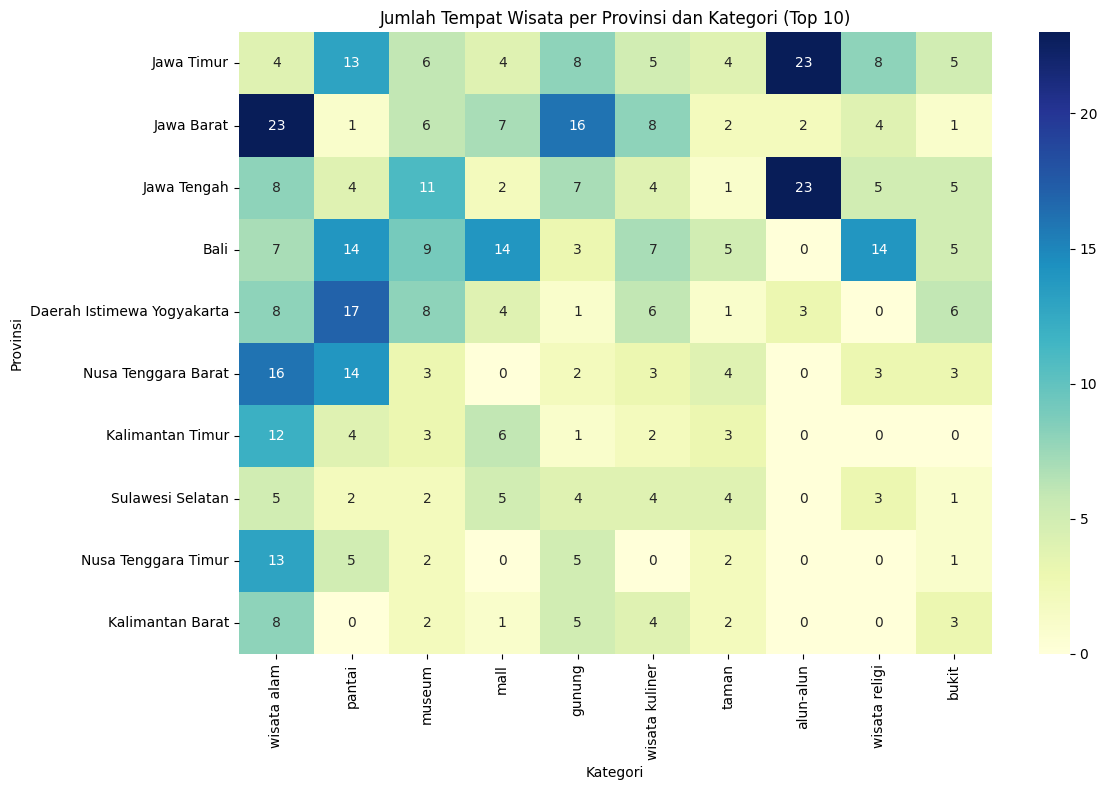

In [11]:
pivot_table = pd.crosstab(df['provinsi'], df['kategori'])
top_kat = df['kategori'].value_counts().nlargest(10).index
top_prov = df['provinsi'].value_counts().nlargest(10).index
pivot_filtered = pivot_table.loc[top_prov, top_kat]
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_filtered, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Jumlah Tempat Wisata per Provinsi dan Kategori (Top 10)')
plt.xlabel("Kategori")
plt.ylabel("Provinsi")
plt.tight_layout()
plt.show()

Visualisasi tersebut adalah sebuah heatmap yang menunjukkan jumlah tempat wisata berdasarkan provinsi dan kategori (10 kategori teratas). Sumbu vertikal (Y) mencantumkan nama-nama provinsi, sedangkan sumbu horizontal (X) mencantumkan berbagai kategori tempat wisata seperti "wisata alam", "pantai", "museum", dan lainnya. Setiap sel dalam heatmap menampilkan angka yang merepresentasikan jumlah tempat wisata untuk kombinasi provinsi dan kategori tertentu. Warna sel mengindikasikan kuantitas: warna yang lebih gelap (biru tua) menunjukkan jumlah tempat wisata yang lebih banyak, sedangkan warna yang lebih terang (kuning muda) menunjukkan jumlah yang lebih sedikit, sebagaimana dijelaskan pada legenda warna di sisi kanan. Secara keseluruhan, heatmap ini memberikan gambaran tentang konsentrasi dan sebaran jenis tempat wisata di berbagai provinsi di Indonesia.

## **EDA Univariate**

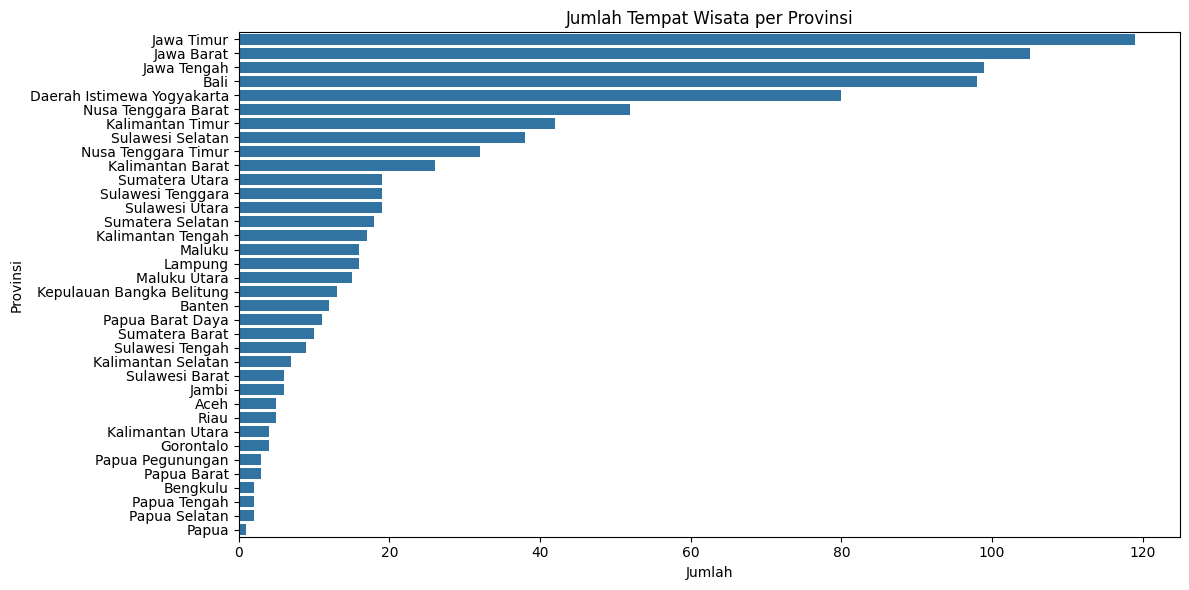

In [12]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='provinsi', order=df['provinsi'].value_counts().index)
plt.title('Jumlah Tempat Wisata per Provinsi')
plt.xlabel('Jumlah')
plt.ylabel('Provinsi')
plt.tight_layout()
plt.show()

Visualisasi data tersebut adalah diagram batang horizontal yang berjudul "Jumlah Tempat Wisata per Provinsi". Diagram ini menampilkan perbandingan jumlah tempat wisata di berbagai provinsi di Indonesia. Sumbu vertikal (Y) mencantumkan nama-nama provinsi, sedangkan sumbu horizontal (X) menunjukkan jumlah tempat wisata. Panjang setiap batang merepresentasikan total tempat wisata di provinsi tersebut; semakin panjang batangnya, semakin banyak jumlah tempat wisatanya. Provinsi-provinsi diurutkan dari yang memiliki jumlah tempat wisata terbanyak (di bagian atas) hingga yang paling sedikit (di bagian bawah), sehingga memudahkan untuk mengidentifikasi provinsi dengan daya tarik wisata tertinggi berdasarkan kuantitas.

In [13]:
df['kota_kabupaten'] = df['kota_kabupaten'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', str(x)))

Membersihkan kolom kota_kabupaten di DataFrame df dengan menghapus semua karakter non-ASCII (karakter yang bukan dari set karakter standar bahasa Inggris). Jadi, hanya karakter ASCII biasa yang akan tersisa di tiap nilai kolom tersebut.

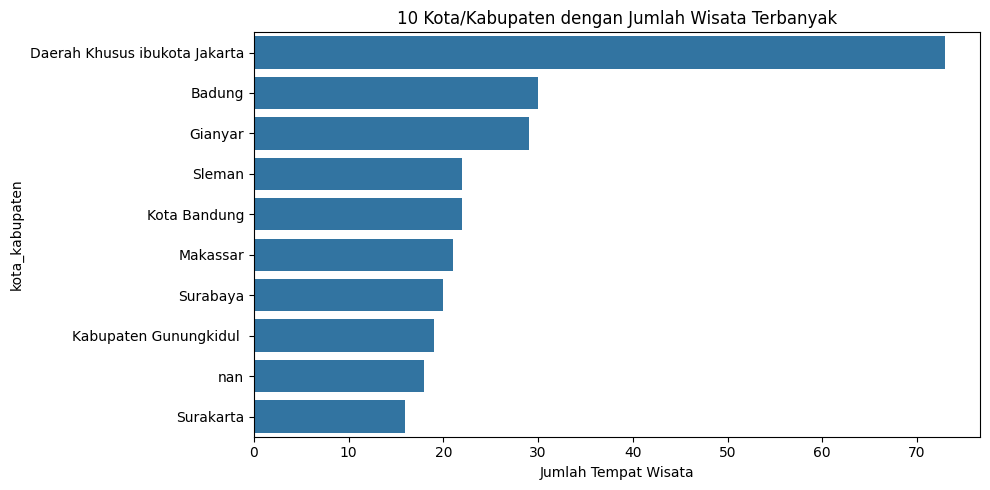

In [14]:
plt.figure(figsize=(10, 5))
top_kota = df['kota_kabupaten'].value_counts().head(10)
sns.barplot(x=top_kota.values, y=top_kota.index)
plt.title('10 Kota/Kabupaten dengan Jumlah Wisata Terbanyak')
plt.xlabel('Jumlah Tempat Wisata')
plt.tight_layout()
plt.show()

Visualisasi data tersebut adalah diagram batang horizontal yang berjudul "Jumlah Tempat Wisata per Provinsi". Diagram ini menampilkan perbandingan jumlah tempat wisata di berbagai provinsi di Indonesia. Sumbu vertikal (Y) mencantumkan nama-nama provinsi, sedangkan sumbu horizontal (X) menunjukkan jumlah tempat wisata. Panjang setiap batang merepresentasikan total tempat wisata di provinsi tersebut; semakin panjang batangnya, semakin banyak jumlah tempat wisatanya. Provinsi-provinsi diurutkan dari yang memiliki jumlah tempat wisata terbanyak (di bagian atas) hingga yang paling sedikit (di bagian bawah), sehingga memudahkan untuk mengidentifikasi provinsi dengan daya tarik wisata tertinggi berdasarkan kuantitas.

# **Data Preprocessing**

In [15]:
print(df.isnull().sum())

kategori           0
nama_wisata        0
latitude           0
longitude          0
alamat             0
provinsi          90
kota_kabupaten     0
nama_lengkap       0
deskripsi          0
path               0
path_gambar        0
dtype: int64


Kolom provinsi memiliki 90 nilai yang kosong (null), sedangkan kolom lainnya tidak ada nilai yang hilang, menunjukkan data hampir lengkap kecuali untuk informasi provinsi pada beberapa baris.

In [16]:
for col in df.columns:
  if df[col].isnull().sum() > 0:
    df[col].fillna(df[col].mode()[0], inplace=True)

print("\nMissing values after filling:")
print(df.isnull().sum())


Missing values after filling:
kategori          0
nama_wisata       0
latitude          0
longitude         0
alamat            0
provinsi          0
kota_kabupaten    0
nama_lengkap      0
deskripsi         0
path              0
path_gambar       0
dtype: int64


<ipython-input-16-397b8c13651b>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


Kode tersebut mengisi nilai kosong (missing values) di setiap kolom dengan nilai modus (nilai yang paling sering muncul) pada kolom tersebut. Setelah proses ini, tidak ada lagi nilai yang kosong di dataset.

In [17]:
df.duplicated().sum()

np.int64(0)

Tidak ditemukan baris data yang duplikat dalam dataset, artinya semua entri unik.

In [18]:
df[df.duplicated('nama_wisata', keep=False)]

,kategori,nama_wisata,latitude,longitude,alamat,provinsi,kota_kabupaten,nama_lengkap,deskripsi,path,path_gambar


Hasil ini menunjukkan tidak ada duplikat pada kolom nama_wisata, sehingga setiap nama wisata memang unik dalam dataset.

In [19]:
def hapus_karakter_rusak(teks):
    return re.sub(r'[^\x00-\x7F]+', ' ', str(teks))

Fungsi hapus_karakter_rusak(teks) digunakan untuk membersihkan teks dari karakter non-ASCII (karakter yang rusak atau tidak dikenali dalam standar ASCII), menggantinya dengan spasi.

In [20]:
def bersihkan_deskripsi(teks):
    teks = hapus_karakter_rusak(teks)
    teks = re.sub(r"==\s*[^=]+?\s*==.*", "", teks, flags=re.IGNORECASE | re.DOTALL)
    teks = re.sub(r"^Berikut(?: ini)?(?: adalah)?(?: daftar)?[^.]*\.", "", teks, flags=re.IGNORECASE)
    teks = re.sub(r"^(Latar belakang|Sejarah singkat)[^.]*\.", "", teks, flags=re.IGNORECASE)
    teks = hapus_karakter_rusak(teks)
    return teks.strip()

Fungsi diatas bertujuan untuk membersihkan kolom deskripsi dari karakter rusak dan kalimat pembuka yang tidak informatif. Langkah-langkahnya:

1. Menghapus karakter non-ASCII.
2. Menghapus bagian dengan pola `== Judul ==` beserta isinya (biasanya format wiki).
3. Menghapus kalimat pembuka umum seperti "Berikut ini adalah daftar..." atau "Latar belakang...".
4. Menghapus ulang karakter non-ASCII jika masih ada.
5. Mengembalikan teks yang sudah dibersihkan dan dipangkas spasinya.

In [21]:
df['provinsi'] = df['provinsi'].str.strip()
df['deskripsi_bersih'] = df['deskripsi'].apply(bersihkan_deskripsi)
df = df.drop(columns=['path', 'deskripsi'])

1. `df['provinsi'] = df['provinsi'].str.strip()`
   Menghapus spasi di awal dan akhir teks pada kolom `provinsi`, mencegah kesalahan saat analisis atau pengelompokan data.
2. `df['deskripsi_bersih'] = df['deskripsi'].apply(bersihkan_deskripsi)`
   Menerapkan fungsi `bersihkan_deskripsi` pada kolom `deskripsi` untuk membuat kolom baru `deskripsi_bersih` yang berisi versi teks yang sudah dibersihkan.
3. `df = df.drop(columns=['path', 'deskripsi'])`
   Menghapus kolom `path` dan `deskripsi` dari DataFrame karena sudah tidak diperlukan lagi (informasi deskripsi telah dipindahkan dan dibersihkan).

In [22]:
# Buat mapping typo ke kategori benar
kategori_mapping = {
    'wisate alam': 'wisata alam',
    'wisath alam': 'wisata alam',
    'wisatr alam': 'wisata alam',
    'wisaub alam': 'wisata alam',
    'wisawa alam': 'wisata alam',
    'wisawi alam': 'wisata alam',
}

# Ganti nilai berdasarkan mapping
df['kategori'] = df['kategori'].replace(kategori_mapping)

Memperbaiki kesalahan penulisan pada kolom kategori dengan mengganti typo seperti "wisate alam" menjadi "wisata alam" agar data lebih konsisten untuk analisis.

In [23]:
df_clean = df.copy()
df_clean

,kategori,nama_wisata,latitude,longitude,alamat,provinsi,kota_kabupaten,nama_lengkap,path_gambar,deskripsi_bersih
0,air terjun,Air Terjun Aling-Aling,-8.176792,115.106284,"Air Terjun Aling-Aling, Panji Anom, Buleleng, ...",Bali,Buleleng,"Air Terjun Aling-Aling, Buleleng, Bali",gambar_wisata/Air_Terjun_Aling-Aling,Deskripsi tidak ditemukan
1,air terjun,Air Terjun Bantimurung,-5.016520,119.685520,"Air Terjun Bantimurung, Jalan Poros Bantimurun...",Sulawesi Selatan,Sulawesi,"Air Terjun Bantimurung, Sulawesi, Sulawesi Sel...",gambar_wisata/Air_Terjun_Bantimurung,Air Terjun Bantimurung adalah salah satu air t...
2,air terjun,Air Terjun Benang Kelambu,-8.532770,116.337011,"Air Terjun Benang Kelambu, Pemotoh, Lombok Ten...",Nusa Tenggara Barat,Lombok Tengah,"Air Terjun Benang Kelambu, Lombok Tengah, Nusa...",gambar_wisata/Air_Terjun_Benang_Kelambu,Deskripsi tidak ditemukan
3,air terjun,Air Terjun Benang Stokel,-8.533036,116.341379,"Air Terjun Benang Stokel, Pemotoh, Lombok Teng...",Nusa Tenggara Barat,Lombok Tengah,"Air Terjun Benang Stokel, Lombok Tengah, Nusa ...",gambar_wisata/Air_Terjun_Benang_Stokel,Deskripsi tidak ditemukan
4,air terjun,Air Terjun Bidadari,-2.928361,107.839043,"Air Terjun Bidadari, Nyuruk, Belitung Timur, K...",Kepulauan Bangka Belitung,Belitung Timur,"Air Terjun Bidadari, Belitung Timur, Kepulauan...",gambar_wisata/Air_Terjun_Bidadari,Daftar ini tidak lengkap dan hanya dapat dijad...
...,...,...,...,...,...,...,...,...,...,...
1020,wisata alam,Situ Cileunca,-7.202004,107.547142,"Situ Cileunca, Kampung Cibuluh, Pulosari, Kabu...",Jawa Barat,Kabupaten Bandung,"Situ Cileunca, Kabupaten Bandung, Jawa Barat",gambar_wisata/Situ_Cileunca,"Situ Cileunca (Aksara Sunda Baku: ), adala..."
1021,wisata alam,Situ Cisanti,-7.209391,107.657477,"Situ Cisanti, Kertasari, Kabupaten Bandung, Ja...",Jawa Barat,Kabupaten Bandung,"Situ Cisanti, Kabupaten Bandung, Jawa Barat",gambar_wisata/Situ_Cisanti,Situ Cisanti (Aksara Sunda Baku: ) adalah d...
1022,wisata alam,Situ Patenggang,-7.165260,107.369782,"Situ Patenggang, Bauan, Rancabali, Kabupaten B...",Jawa Barat,Kabupaten Bandung,"Situ Patenggang, Kabupaten Bandung, Jawa Barat",gambar_wisata/Situ_Patenggang,Situ Patenggang atau Situ Patengan adalah suat...
1023,wisata alam,Situ Rawa Gede,-6.292928,106.977288,"Situ Rawa Gede, Pesona Metropolitan, Bojong Me...",Jawa Barat,Bekasi,"Situ Rawa Gede, Bekasi, Jawa Barat",gambar_wisata/Situ_Rawa_Gede,Kabupaten Purwakarta (bahasa Sunda: ) adalah ...


Kode diatas digunakan untuk membuat salinan dari DataFrame df ke dalam variabel baru df_clean, sehingga perubahan selanjutnya pada df_clean tidak memengaruhi DataFrame asli df.

In [24]:
csv_string = df_clean.to_csv(index=False)
from google.colab import files
with open('wisata_indonesia_final.csv', 'w') as f:
  f.write(csv_string)

files.download('wisata_indonesia_final.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Menyimpan DataFrame df_clean ke dalam file CSV bernama wisata_indonesia_final.csv tanpa menyertakan indeks, lalu file tersebut langsung disiapkan untuk diunduh melalui Google Colab menggunakan files.download().

In [25]:
preferred_categories = ["gunung", "taman", "pantai"]
user_provinsi = "Jawa Timur"

filtered_df = df_clean[df_clean['provinsi'].str.lower() == user_provinsi.lower()].copy()
filtered_df['label'] = filtered_df['kategori'].apply(lambda x: 1 if x in preferred_categories else 0)


print("Data setelah filter:", filtered_df.shape)

Data setelah filter: (209, 11)


Memfilter data wisata hanya untuk provinsi Jawa Timur, lalu menambahkan kolom baru bernama label yang bernilai 1 jika kategori wisata termasuk dalam daftar preferensi pengguna ("gunung", "taman", "pantai"), dan 0 jika tidak. Hasilnya, data yang tersisa berjumlah 209 baris.

# **Modelling: Skor Cosine Similarity**

In [26]:
tfidf = TfidfVectorizer(stop_words=stopwords_indonesia)
tfidf_matrix = tfidf.fit_transform(filtered_df['deskripsi_bersih'])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


Menginisialisasi vektorisasi teks dengan mengabaikan kata-kata umum dalam Bahasa Indonesia.


In [27]:
user_pref_kategori = " ".join(preferred_categories)
user_vector = tfidf.transform([user_pref_kategori])
cosine_sim = cosine_similarity(user_vector, tfidf_matrix).flatten()

Tahapan diatas mengubah preferensi kategori pengguna menjadi vektor TF-IDF lalu menghitung tingkat kemiripannya dengan deskripsi wisata menggunakan cosine similarity, sehingga bisa menilai seberapa relevan setiap tempat wisata dengan preferensi tersebut.

In [28]:
filtered_df['score'] = cosine_sim

Tahapan diatas merupakan proses menambahkan kolom baru bernama score ke filtered_df, yang berisi nilai kemiripan (cosine similarity) antara preferensi pengguna dan deskripsi tempat wisata, sebagai ukuran relevansi tiap wisata dengan preferensi tersebut.

# **Feature Engineering**

In [29]:
filtered_df['desc_len'] = filtered_df['deskripsi_bersih'].apply(lambda x: len(str(x).split()))

Menambahkan kolom baru desc_len ke filtered_df yang berisi jumlah kata dari setiap deskripsi wisata yang sudah dibersihkan, sebagai ukuran panjang teks deskripsi.

In [30]:
le_kategori = LabelEncoder()
le_provinsi = LabelEncoder()

Membuat dua objek `LabelEncoder` dari scikit-learn untuk nantinya mengubah data kategorikal pada kolom `kategori` dan `provinsi` menjadi angka agar bisa digunakan dalam pemodelan machine learning.

In [31]:
filtered_df['desc_len'] = filtered_df['deskripsi_bersih'].apply(lambda x: len(str(x).split()))
filtered_df['kategori_enc'] = le_kategori.fit_transform(filtered_df['kategori'])
filtered_df['provinsi_enc'] = le_provinsi.fit_transform(filtered_df['provinsi'])
filtered_df['is_preferred_category'] = filtered_df['kategori'].apply(lambda x: 1 if x in preferred_categories else 0)

Menambahkan beberapa kolom baru pada filtered_df: desc_len untuk panjang deskripsi dalam jumlah kata, kategori_enc dan provinsi_enc sebagai representasi numerik hasil encoding dari kolom kategori dan provinsi, serta is_preferred_category yang menandai baris dengan 1 jika kategori termasuk kategori favorit pengguna dan 0 jika tidak.

In [32]:
X = filtered_df[['kategori_enc', 'provinsi_enc', 'desc_len', 'is_preferred_category']]
y = filtered_df['score']

Menetapkan variabel fitur X yang berisi kolom-kolom numerik dan indikator dari data wisata, serta variabel target y yang berisi skor kemiripan antara preferensi pengguna dengan deskripsi wisata, untuk digunakan dalam pemodelan atau analisis selanjutnya.

In [33]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Melakukan normalisasi fitur-fitur di X menggunakan MinMaxScaler agar nilainya berada dalam rentang 0 hingga 1, sehingga membantu meningkatkan performa dan kestabilan model machine learning.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Membagi data fitur (X_scaled) dan target (y) menjadi dua set: data pelatihan (80%) dan data pengujian (20%) dengan pengacakan yang konsisten menggunakan random_state=42 untuk evaluasi model yang lebih valid.

In [35]:
df_clean['kategori'].unique()

array(['air terjun', 'alun-alun', 'bukit', 'cafe view', 'candi', 'gunung',
       'kebun binatang', 'lembah', 'mall', 'monumen', 'museum', 'pantai',
       'rumah adat', 'taman', 'wahana keluarga', 'wisata  religi',
       'wisata alam', 'wisata edukasi', 'wisata kerajaan',
       'wisata kuliner', 'wisata lampion', 'wisata religi',
       'wisata tematik'], dtype=object)

Dari data kategori unik pada df_clean, terlihat ada beberapa variasi kategori wisata seperti 'air terjun', 'pantai', 'museum', dan 'wisata religi' yang tertulis dua kali dengan ejaan sedikit berbeda ('wisata religi' dan 'wisata religi'), menandakan perlu pembersihan atau normalisasi lebih lanjut pada kolom kategori.

# **Modelling dengan TensorFlow**

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Input(batch_shape=(4, 4)),  # <-- batch size = 4, fitur = 4
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

Tahapan di atas mendefinisikan model neural network menggunakan Keras Sequential dengan input berukuran batch 4 dan 4 fitur. Model ini memiliki dua lapisan Dense dengan aktivasi ReLU (64 dan 32 neuron) yang masing-masing diikuti Dropout untuk mengurangi overfitting. Outputnya satu neuron dengan aktivasi sigmoid, cocok untuk regresi dengan output antara 0 dan 1. Model dikompilasi menggunakan optimizer Adam, loss fungsi mean squared error (mse), dan metrik mean absolute error (mae).

In [37]:
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.2)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.2368 - mae: 0.4769 - val_loss: 0.1979 - val_mae: 0.4331
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1922 - mae: 0.4270 - val_loss: 0.1604 - val_mae: 0.3877
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1590 - mae: 0.3834 - val_loss: 0.1308 - val_mae: 0.3489
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1311 - mae: 0.3462 - val_loss: 0.1050 - val_mae: 0.3104
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1031 - mae: 0.2991 - val_loss: 0.0814 - val_mae: 0.2697
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0858 - mae: 0.2773 - val_loss: 0.0611 - val_mae: 0.2317
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0651 - mae: 0.2382 - val_loss: 0.0457 - val_mae: 0.2004
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0451 - mae: 0.1970 - val_loss: 0.0350 - val_mae: 0.1739
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0394 - mae: 0.1819 - 

Training model selama 30 epoch menunjukkan penurunan loss dan MAE (mean absolute error) secara konsisten pada data pelatihan maupun validasi, yang berarti model semakin baik dalam memprediksi skor kesamaan deskripsi. Nilai loss yang semakin kecil (mse turun dari 0.19 ke 0.0072) dan MAE juga berkurang (dari 0.42 ke sekitar 0.05) menandakan model belajar dengan efektif tanpa tanda-tanda overfitting yang jelas, karena validasi error juga menurun. Hal ini menunjukkan model neural network berhasil memetakan fitur input ke skor kesamaan secara akurat.

# **Evaluasi Model**

In [38]:
# Ambil ground truth dan hasil rekomendasi
filtered_df['label'] = filtered_df['kategori'].apply(lambda x: 1 if x in preferred_categories else 0)

# Urutkan berdasarkan skor cosine similarity
filtered_df_sorted = filtered_df.sort_values(by='score', ascending=False)
top_k = 10
top_k_recommendations = filtered_df_sorted.head(top_k)
ground_truth = filtered_df[filtered_df['label'] == 1]['nama_wisata'].values
predicted = top_k_recommendations['nama_wisata'].values

def precision_recall_at_k(ground_truth, predicted, k):
    predicted_k = predicted[:k]
    relevant = set(ground_truth)
    retrieved = set(predicted_k)
    true_positive = relevant.intersection(retrieved)

    precision = len(true_positive) / k
    recall = len(true_positive) / len(relevant) if len(relevant) > 0 else 0.0

    return precision, recall

precision, recall = precision_recall_at_k(ground_truth, predicted, top_k)
print(f"Precision@{top_k}: {precision:.2f}")
print(f"Recall@{top_k}: {recall:.2f}")

Precision@10: 1.00
Recall@10: 0.28


Hasil evaluasi menunjukkan Precision@10 sebesar 1.00, artinya dari 10 rekomendasi teratas yang diberikan, semuanya memang termasuk kategori yang diinginkan (tidak ada yang salah). Namun, Recall@10 hanya 0.28, yang berarti hanya sekitar 28% dari seluruh objek wisata yang sebenarnya masuk kategori favorit berhasil direkomendasikan dalam 10 besar tersebut.

In [39]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Loss: {loss:.4f} | MAE: {mae:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0035 - mae: 0.0362
Loss: 0.0046 | MAE: 0.0394


Model menunjukkan performa yang baik dengan nilai loss (MSE) sekitar 0.0037 dan Mean Absolute Error (MAE) sebesar 0.0385 pada data uji, yang mengindikasikan prediksi model cukup akurat dan kesalahan rata-rata prediksi terhadap nilai sebenarnya relatif kecil.

# **Prediksi & Rekomendasi**

In [40]:
filtered_df['predicted_score'] = model.predict(X_scaled).flatten()
top_rekomendasi = filtered_df.sort_values(by='predicted_score', ascending=False).head(10)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Tahapan tersebut menambahkan kolom predicted_score ke filtered_df yang berisi hasil prediksi skor dari model untuk setiap data, kemudian mengurutkan data berdasarkan skor prediksi dari yang tertinggi dan mengambil 10 teratas sebagai rekomendasi terbaik.

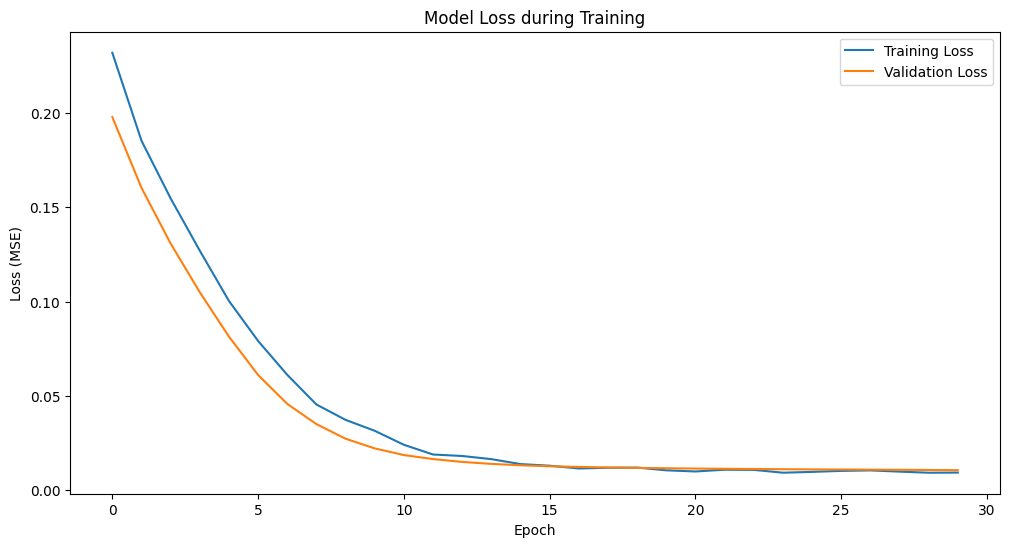

In [41]:
import matplotlib.pyplot as plt
# Visualisasi hasil evaluasi model
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

Visualisasi diatas menunjukkan bahwa baik training loss maupun validation loss menurun secara signifikan pada epoch-epoch awal, kemudian melambat dan stabil pada nilai rendah setelah sekitar 15 epoch. Hal tersebut mengindikasikan bahwa model belajar dengan baik dan tidak menunjukkan tanda-tanda overfitting yang parah karena validation loss juga mengikuti tren penurunan training loss dan tetap berada pada tingkat yang serupa.

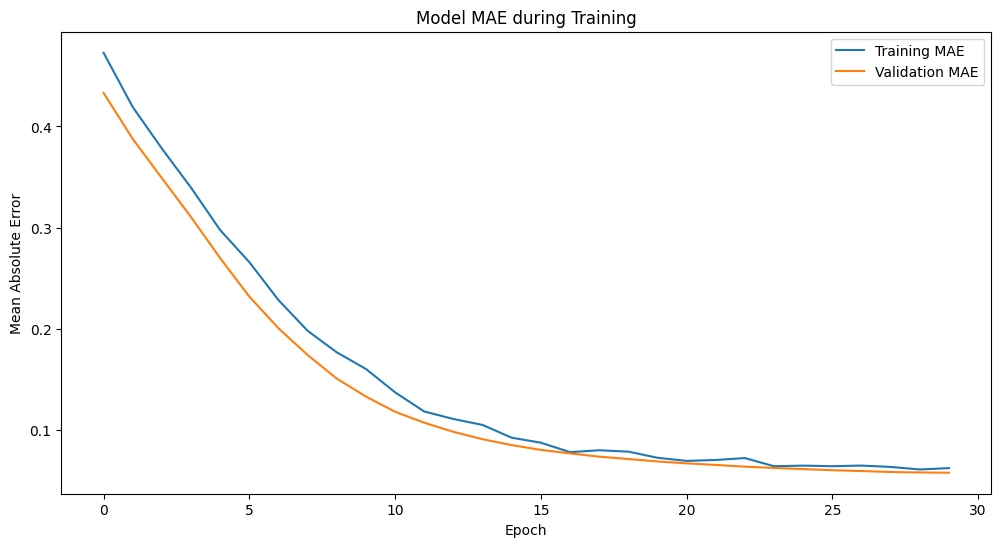

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE during Training')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

Visualisasi diatas menunjukkan Mean Absolute Error (MAE) dari model selama proses pelatihan. Baik training MAE maupun validation MAE menunjukkan penurunan yang signifikan pada epoch-epoch awal dan kemudian stabil pada nilai yang rendah setelah sekitar 15 epoch. Kurva training MAE dan validation MAE yang relatif dekat menunjukkan bahwa model belajar dengan baik tanpa tanda-tanda overfitting yang jelas, karena kinerja pada data yang tidak terlihat (validasi) tetap konsisten dengan kinerja pada data pelatihan.

# Rekomendasi dari Preferensi User

In [43]:
def rekomendasi_wisata_berbobot(preferred_categories, user_provinsi, df, model, le_kategori, le_provinsi, scaler, weight_model=0.3, weight_tfidf=0.7):
    # Filter data sesuai provinsi
    filtered_df = df[df['provinsi'].str.lower() == user_provinsi.lower()].copy()
    if 'deskripsi_bersih' not in filtered_df.columns:
        filtered_df['deskripsi_bersih'] = filtered_df['deskripsi'].apply(bersihkan_deskripsi)

    # Hitung TF-IDF cosine similarity
    tfidf = TfidfVectorizer(stop_words=stopwords_indonesia)
    tfidf_matrix = tfidf.fit_transform(filtered_df['deskripsi_bersih'])
    user_pref_kategori = " ".join(preferred_categories)
    user_vector = tfidf.transform([user_pref_kategori])
    cosine_sim = cosine_similarity(user_vector, tfidf_matrix).flatten()
    filtered_df['cosine_score'] = cosine_sim

    # Feature engineering untuk model
    filtered_df['desc_len'] = filtered_df['deskripsi_bersih'].apply(lambda x: len(str(x).split()))
    filtered_df['kategori_enc'] = le_kategori.transform(filtered_df['kategori'])
    filtered_df['provinsi_enc'] = le_provinsi.transform(filtered_df['provinsi'])
    filtered_df['is_preferred_category'] = filtered_df['kategori'].apply(lambda x: 1 if x in preferred_categories else 0)

    X = filtered_df[['kategori_enc', 'provinsi_enc', 'desc_len', 'is_preferred_category']]
    X_scaled = scaler.transform(X)

    # Prediksi skor dengan model TensorFlow
    filtered_df['model_score'] = model.predict(X_scaled).flatten()
    filtered_df['final_score'] = weight_model * filtered_df['model_score'] + weight_tfidf * filtered_df['cosine_score']

    # Ambil top 10 rekomendasi berdasarkan final_score
    top_rekomendasi = filtered_df.sort_values(by='final_score', ascending=False).head(10)

    # Tampilkan kolom yang diminta plus skor
    return top_rekomendasi[['nama_wisata', 'provinsi', 'alamat', 'deskripsi_bersih', 'kota_kabupaten', 'final_score', 'cosine_score', 'model_score']]

Fungsi ini memberikan rekomendasi wisata di provinsi tertentu dengan menggabungkan skor prediksi model dan skor kemiripan TF-IDF berdasarkan preferensi kategori pengguna, lalu mengembalikan 10 wisata dengan skor tertinggi beserta informasinya.

In [44]:
valid_categories = df_clean["kategori"].unique()

filtered_preferred_categories = [cat for cat in preferred_categories if cat in valid_categories]

if not filtered_preferred_categories:
    print("Maaf, tidak ada kategori yang cocok dengan preferensi Anda.")
else:
    hasil_rekomendasi = rekomendasi_wisata_berbobot(
        filtered_preferred_categories,
        user_provinsi,
        df_clean,
        model,
        le_kategori,
        le_provinsi,
        scaler
    )
    print(hasil_rekomendasi)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
                nama_wisata    provinsi  \
512        Pantai Rajegwesi  Jawa Timur   
574  Taman Nasional Baluran  Jawa Timur   
453             Pantai Boom  Jawa Timur   
225           Gunung Semeru  Jawa Timur   
169           Gunung Arjuno  Jawa Timur   
529       Pantai Tambakrejo  Jawa Timur   
509        Pantai Plengkung  Jawa Timur   
239         Gunung Welirang  Jawa Timur   
473           Pantai Klayar  Jawa Timur   
511            Pantai Popoh  Jawa Timur   

                                                alamat  \
512  Pantai Rajegwesi, Rajegwesi, Banyuwangi, Jawa ...   
574  Taman Nasional Baluran, Situbondo, Banyuwangi,...   
453  Pantai Boom, Krajan, Banyuwangi, Kampungmandar...   
225  Gunung Semeru, Lumajang, Jawa Timur, Jawa, Ind...   
169  Gunung Arjuno, Bumirejo, Kabupaten Malang, Jaw...   
529  Pantai Tambakrejo, Jalan Pantai, Tambakrejo, B...   
509  Pantai Plengkung, G-Land, Banyuwangi, Jawa Tim...   
239  Gunung Welirang, Pa

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


Tahapan tersebut memeriksa apakah kategori favorit pengguna ada di data, jika tidak ada maka memberi pesan bahwa tidak ada kategori cocok; jika ada, maka menjalankan fungsi rekomendasi berbobot dan menampilkan hasil rekomendasi wisata sesuai preferensi dan provinsi pengguna.

In [45]:
model.save("my_model.h5")

Menyimpan model TensorFlow/Keras yang sudah dilatih ke dalam file dengan format HDF5 (.h5). File ini berisi arsitektur model, bobot (weights), dan konfigurasi pelatihan, sehingga nanti model bisa dimuat kembali tanpa perlu melatih ulang.

In [46]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.33.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [47]:
!tensorflowjs_converter --input_format=keras my_model.h5 tfjs_model/

2025-05-30 03:37:37.436624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748576257.462865    1214 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748576257.469987    1214 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


Perintah diatas digunakan untuk mengonversi model Keras (my_model.h5) ke format TensorFlow.js agar bisa digunakan di aplikasi web dengan TensorFlow.js.

In [48]:
!zip -r tfjs.zip tfjs_model/
files.download('tfjs.zip')

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard1of1.bin (deflated 7%)
  adding: tfjs_model/model.json (deflated 79%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tahapan tersebut mengompres folder tfjs_model yang berisi model TensorFlow.js menjadi file tfjs.zip, lalu memulai proses pengunduhan file zip tersebut ke komputer. Dengan cara ini, model yang sudah dikonversi dapat dengan mudah disimpan atau dipindahkan untuk digunakan di proyek web.